In [1]:
import pandas as pd
import numpy as np 
# import plotly
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.probability import FreqDist
from os import path 
from PIL import Image 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline


# Data Cleaning

In [2]:
# Get the price data
house_price_raw = pd.read_excel('RealProp_4.28.20.xlsx')

In [3]:
house_price_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238424 entries, 0 to 238423
Data columns (total 80 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   OBJECTID       238424 non-null  int64  
 1   PIN            238424 non-null  object 
 2   PINRELATE      238424 non-null  object 
 3   BLOCKLOT       238424 non-null  object 
 4   BLOCK          238424 non-null  object 
 5   LOT            238424 non-null  object 
 6   WARD           238424 non-null  int64  
 7   SECTION        238424 non-null  int64  
 8   ASSESSOR       238424 non-null  object 
 9   TAXBASE        238424 non-null  int64  
 10  BFCVLAND       132111 non-null  float64
 11  BFCVIMPR       238424 non-null  int64  
 12  LANDEXMP       238424 non-null  int64  
 13  IMPREXMP       238424 non-null  int64  
 14  CITYCRED       234220 non-null  float64
 15  STATCRED       238424 non-null  float64
 16  CCREDAMT       238424 non-null  float64
 17  SCREDAMT       238181 non-nul

In [4]:
house_price_filter = house_price_raw.filter(items = ['PIN','BLOCK','LOT','TAXBASE','FULLCASH'])
house_price_filter['VALUE'] = house_price_filter['TAXBASE'] + house_price_filter['FULLCASH']
house_price_filter.head(100)

,PIN,BLOCK,LOT,TAXBASE,FULLCASH,VALUE
0,0001001,0001,001,141800,0,141800
1,0001002,0001,002,49500,0,49500
2,0001003,0001,003,7000,0,7000
3,0001004,0001,004,7000,0,7000
4,0001005,0001,005,21667,0,21667
...,...,...,...,...,...,...
95,0002043,0002,043,5333,0,5333
96,0002044,0002,044,6000,0,6000
97,0002045,0002,045,5333,0,5333
98,0002046,0002,046,36667,0,36667


In [5]:
house_permit_from_file = pd.read_csv('Housing_Permits.csv',dtype = 'unicode')
house_permit_from_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634950 entries, 0 to 634949
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   PermitID                     634950 non-null  object
 1   CaseNum                      634950 non-null  object
 2   Block                        634947 non-null  object
 3   Lot                          634947 non-null  object
 4   PropertyAddress              634882 non-null  object
 5   PermitNum                    634950 non-null  object
 6   DateIssue                    634950 non-null  object
 7   PermitDescription            615005 non-null  object
 8   Cost_Est                     468980 non-null  object
 9   DateExpire                   577165 non-null  object
 10  Prop_Use                     582264 non-null  object
 11  Existing_Use                 582436 non-null  object
 12  Neighborhood                 611060 non-null  object
 13  PoliceDistrict

In [6]:
# Question 1 What types of construction permits are people pulling?
house_permit_from_file['PermitDescription'] = house_permit_from_file['PermitDescription'].astype(str)
house_permit_from_file['Location'] = house_permit_from_file['Location'].astype(str)
house_permit_from_file = house_permit_from_file[house_permit_from_file['PermitDescription'].notnull()]


In [7]:
house_permit_from_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634950 entries, 0 to 634949
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   PermitID                     634950 non-null  object
 1   CaseNum                      634950 non-null  object
 2   Block                        634947 non-null  object
 3   Lot                          634947 non-null  object
 4   PropertyAddress              634882 non-null  object
 5   PermitNum                    634950 non-null  object
 6   DateIssue                    634950 non-null  object
 7   PermitDescription            634950 non-null  object
 8   Cost_Est                     468980 non-null  object
 9   DateExpire                   577165 non-null  object
 10  Prop_Use                     582264 non-null  object
 11  Existing_Use                 582436 non-null  object
 12  Neighborhood                 611060 non-null  object
 13  PoliceDistrict

In [8]:
# Create PIN in house_permit form
house_permit_from_file['Block'] = house_permit_from_file['Block'].str.zfill(4)
house_permit_from_file['Lot'] = house_permit_from_file['Lot'].str.zfill(3)
house_permit_from_file['PIN'] = house_permit_from_file['Block'] + house_permit_from_file['Lot']
house_permit_from_file.head()

,PermitID,CaseNum,Block,Lot,PropertyAddress,PermitNum,DateIssue,PermitDescription,Cost_Est,DateExpire,Prop_Use,Existing_Use,Neighborhood,PoliceDistrict,CouncilDistrict,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,PIN
0,20151202163056763B,COM2015-28907,1451,014,1752 N GAY ST,COM2015-28907,03/28/2019,interior and exterior alteration of an existin...,700000.00,03/28/2021,ASM,ASM,BROADWAY EAST,Eastern,12,"1752 N GAY ST\nBaltimore, MD\n(39.310536, -76....",23,148,26956,1451014
1,20180215133007957B,DEM2018-50023,4250,041,3401 LABYRINTH RD,DEM2018-50023,03/28/2019,demolition of building/structure(wood)(1) leng...,0.00,09/28/2019,NaN,1-05,CROSS COUNTRY,Northwestern,5,"3401 LABYRINTH RD\nBaltimore, MD\n(39.3669, -7...",58,276,27295,4250041
2,200805211220025130,COM2008-14406,3463F,005B,815 BROOKS LANE,COM2008-14406,06/05/2008,new windows (13) 2-new exterior doors ceramic...,12000.00,12/05/2008,SF,VAC,RESERVOIR HILL,Central,7,"815 BROOKS LANE\nBaltimore, MD\n(39.315946, -7...",210,17,27301,3463F005B
3,20191223163008790B,COM2019-88744,0340,022,1743 DRUID HILL AVE,COM2019-88744,12/26/2019,*authorization to proceed* install new sanitar...,5375.00,03/26/2020,1-08,1-08,UPTON,Central,11,"1743 DRUID HILL AVE\nBaltimore, MD\n(39.305789...",242,99,27301,0340022
4,20191226090221863B,COM2019-88854,5088,012,6026 PINEHURST RD,COM2019-88854,12/26/2019,install (13) # plumbing fixtures (1) # sani...,5500.00,06/26/2020,1-05,1-05,LAKE EVESHAM,Northern,4,"6026 PINEHURST RD\nBaltimore, MD\n(39.367377, ...",132,271,14009,5088012


In [9]:
# Since pandas dataframe would store the address of the string, it would always show strings as object. Remeber to use .str to refer to it 
house_permit_from_file['Location_list'] = house_permit_from_file['Location'].str.split()
house_permit_from_file.head()

,PermitID,CaseNum,Block,Lot,PropertyAddress,PermitNum,DateIssue,PermitDescription,Cost_Est,DateExpire,...,Existing_Use,Neighborhood,PoliceDistrict,CouncilDistrict,Location,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes,PIN,Location_list
0,20151202163056763B,COM2015-28907,1451,014,1752 N GAY ST,COM2015-28907,03/28/2019,interior and exterior alteration of an existin...,700000.00,03/28/2021,...,ASM,BROADWAY EAST,Eastern,12,"1752 N GAY ST\nBaltimore, MD\n(39.310536, -76....",23,148,26956,1451014,"[1752, N, GAY, ST, Baltimore,, MD, (39.310536,..."
1,20180215133007957B,DEM2018-50023,4250,041,3401 LABYRINTH RD,DEM2018-50023,03/28/2019,demolition of building/structure(wood)(1) leng...,0.00,09/28/2019,...,1-05,CROSS COUNTRY,Northwestern,5,"3401 LABYRINTH RD\nBaltimore, MD\n(39.3669, -7...",58,276,27295,4250041,"[3401, LABYRINTH, RD, Baltimore,, MD, (39.3669..."
2,200805211220025130,COM2008-14406,3463F,005B,815 BROOKS LANE,COM2008-14406,06/05/2008,new windows (13) 2-new exterior doors ceramic...,12000.00,12/05/2008,...,VAC,RESERVOIR HILL,Central,7,"815 BROOKS LANE\nBaltimore, MD\n(39.315946, -7...",210,17,27301,3463F005B,"[815, BROOKS, LANE, Baltimore,, MD, (39.315946..."
3,20191223163008790B,COM2019-88744,0340,022,1743 DRUID HILL AVE,COM2019-88744,12/26/2019,*authorization to proceed* install new sanitar...,5375.00,03/26/2020,...,1-08,UPTON,Central,11,"1743 DRUID HILL AVE\nBaltimore, MD\n(39.305789...",242,99,27301,0340022,"[1743, DRUID, HILL, AVE, Baltimore,, MD, (39.3..."
4,20191226090221863B,COM2019-88854,5088,012,6026 PINEHURST RD,COM2019-88854,12/26/2019,install (13) # plumbing fixtures (1) # sani...,5500.00,06/26/2020,...,1-05,LAKE EVESHAM,Northern,4,"6026 PINEHURST RD\nBaltimore, MD\n(39.367377, ...",132,271,14009,5088012,"[6026, PINEHURST, RD, Baltimore,, MD, (39.3673..."


In [10]:
# house_permit_from_file['Length'] = house_permit_from_file['Location_list'].str.len()
# house_permit_from_file.head()

In [11]:
# Get latitude and longitude by spliting the string 
house_permit_from_file['lat'] = house_permit_from_file['Location_list'].str[-2].str.strip('(')
house_permit_from_file['lat'] = house_permit_from_file['lat'].str.strip(',')
house_permit_from_file = house_permit_from_file[house_permit_from_file['lat'].notnull()]
house_permit_from_file = house_permit_from_file[house_permit_from_file['lat'].str.contains('3')]
house_permit_from_file['long'] = house_permit_from_file['Location_list'].str[-1].str.strip(')')
house_permit_from_file['lat'] = house_permit_from_file['lat'].astype(float)
house_permit_from_file['long'] = house_permit_from_file['long'].astype(float)
house_permit_from_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626186 entries, 0 to 634949
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   PermitID                     626186 non-null  object 
 1   CaseNum                      626186 non-null  object 
 2   Block                        626183 non-null  object 
 3   Lot                          626183 non-null  object 
 4   PropertyAddress              626118 non-null  object 
 5   PermitNum                    626186 non-null  object 
 6   DateIssue                    626186 non-null  object 
 7   PermitDescription            626186 non-null  object 
 8   Cost_Est                     462160 non-null  object 
 9   DateExpire                   569374 non-null  object 
 10  Prop_Use                     573950 non-null  object 
 11  Existing_Use                 574116 non-null  object 
 12  Neighborhood                 604811 non-null  object 
 13 

In [12]:
house_permit_from_file['lowercase'] = house_permit_from_file['PermitDescription'].str.lower()

In [13]:
# First time, please uncomment the following line and download punkt. But once you have that, you don't have to redownload it again. 
# This would take about 1-3 minutes to download depending on your network
# nltk.download('punkt')
house_permit_from_file['tokenized_text'] = house_permit_from_file['lowercase'].apply(word_tokenize)

In [14]:
house_permit_from_file_filter = house_permit_from_file.filter(items = ['PropertyAddress','lat','long','lowercase','PIN','DateIssue','Cost_Est','tokenized_text']).reset_index()
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,Cost_Est,tokenized_text
0,0,1752 N GAY ST,39.310536,-76.586421,interior and exterior alteration of an existin...,1451014,03/28/2019,700000.00,"[interior, and, exterior, alteration, of, an, ..."
1,1,3401 LABYRINTH RD,39.366900,-76.698112,demolition of building/structure(wood)(1) leng...,4250041,03/28/2019,0.00,"[demolition, of, building/structure, (, wood, ..."
2,2,815 BROOKS LANE,39.315946,-76.634808,new windows (13) 2-new exterior doors ceramic...,3463F005B,06/05/2008,12000.00,"[new, windows, (, 13, ), 2-new, exterior, door..."
3,3,1743 DRUID HILL AVE,39.305789,-76.633306,*authorization to proceed* install new sanitar...,0340022,12/26/2019,5375.00,"[*authorization, to, proceed*, install, new, s..."
4,4,6026 PINEHURST RD,39.367377,-76.615552,install (13) # plumbing fixtures (1) # sani...,5088012,12/26/2019,5500.00,"[install, (, 13, ), #, plumbing, fixtures, (, ..."


In [15]:
#nltk.download('stopwords')
stop_words=set(stopwords.words("english"))
house_permit_from_file_filter['no_stopwords'] = house_permit_from_file_filter['tokenized_text'].apply(lambda tokenized_list:[word for word in tokenized_list if word not in stop_words])

In [16]:
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,Cost_Est,tokenized_text,no_stopwords
0,0,1752 N GAY ST,39.310536,-76.586421,interior and exterior alteration of an existin...,1451014,03/28/2019,700000.00,"[interior, and, exterior, alteration, of, an, ...","[interior, exterior, alteration, existing, bui..."
1,1,3401 LABYRINTH RD,39.366900,-76.698112,demolition of building/structure(wood)(1) leng...,4250041,03/28/2019,0.00,"[demolition, of, building/structure, (, wood, ...","[demolition, building/structure, (, wood, ), (..."
2,2,815 BROOKS LANE,39.315946,-76.634808,new windows (13) 2-new exterior doors ceramic...,3463F005B,06/05/2008,12000.00,"[new, windows, (, 13, ), 2-new, exterior, door...","[new, windows, (, 13, ), 2-new, exterior, door..."
3,3,1743 DRUID HILL AVE,39.305789,-76.633306,*authorization to proceed* install new sanitar...,0340022,12/26/2019,5375.00,"[*authorization, to, proceed*, install, new, s...","[*authorization, proceed*, install, new, sanit..."
4,4,6026 PINEHURST RD,39.367377,-76.615552,install (13) # plumbing fixtures (1) # sani...,5088012,12/26/2019,5500.00,"[install, (, 13, ), #, plumbing, fixtures, (, ...","[install, (, 13, ), #, plumbing, fixtures, (, ..."


In [17]:
# Remove symbols and numeric value 
symbol_list = ["!", ")","(", ":", ",",".", "...","-", "|", "'",'"','’','…',"“","”","&","^",";","@","#","$","%","_","+","="]
stop_words.update(symbol_list)
house_permit_from_file_filter['no_symbols'] = house_permit_from_file_filter['no_stopwords'].apply(lambda x: [word for word in x if word not in stop_words])
house_permit_from_file_filter['no_symbols'] = house_permit_from_file_filter['no_symbols'].apply(lambda x: [word for word in x if not word.isnumeric()])
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,Cost_Est,tokenized_text,no_stopwords,no_symbols
0,0,1752 N GAY ST,39.310536,-76.586421,interior and exterior alteration of an existin...,1451014,03/28/2019,700000.00,"[interior, and, exterior, alteration, of, an, ...","[interior, exterior, alteration, existing, bui...","[interior, exterior, alteration, existing, bui..."
1,1,3401 LABYRINTH RD,39.366900,-76.698112,demolition of building/structure(wood)(1) leng...,4250041,03/28/2019,0.00,"[demolition, of, building/structure, (, wood, ...","[demolition, building/structure, (, wood, ), (...","[demolition, building/structure, wood, length:..."
2,2,815 BROOKS LANE,39.315946,-76.634808,new windows (13) 2-new exterior doors ceramic...,3463F005B,06/05/2008,12000.00,"[new, windows, (, 13, ), 2-new, exterior, door...","[new, windows, (, 13, ), 2-new, exterior, door...","[new, windows, 2-new, exterior, doors, ceramic..."
3,3,1743 DRUID HILL AVE,39.305789,-76.633306,*authorization to proceed* install new sanitar...,0340022,12/26/2019,5375.00,"[*authorization, to, proceed*, install, new, s...","[*authorization, proceed*, install, new, sanit...","[*authorization, proceed*, install, new, sanit..."
4,4,6026 PINEHURST RD,39.367377,-76.615552,install (13) # plumbing fixtures (1) # sani...,5088012,12/26/2019,5500.00,"[install, (, 13, ), #, plumbing, fixtures, (, ...","[install, (, 13, ), #, plumbing, fixtures, (, ...","[install, plumbing, fixtures, sanitary, connec..."


In [18]:
# remove common words
common_word_list = ['per','code','instal','new','permit','work']
common_word_set = set(common_word_list)
house_permit_from_file_filter['remove_common_word'] = house_permit_from_file_filter['no_symbols'].apply(lambda x: [word for word in x if word not in common_word_set])

In [19]:
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['no_stopwords'].apply(lambda x: [word for word in x if word not in stop_words])
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['tokenized_final'].apply(lambda x: [word for word in x if not word.isnumeric()])
house_permit_from_file_filter['tokenized_final'] = house_permit_from_file_filter['tokenized_final'].apply(lambda x: [word for word in x if word not in common_word_set])

In [20]:
house_permit_from_file_filter.head()

,index,PropertyAddress,lat,long,lowercase,PIN,DateIssue,Cost_Est,tokenized_text,no_stopwords,no_symbols,remove_common_word,tokenized_final
0,0,1752 N GAY ST,39.310536,-76.586421,interior and exterior alteration of an existin...,1451014,03/28/2019,700000.00,"[interior, and, exterior, alteration, of, an, ...","[interior, exterior, alteration, existing, bui...","[interior, exterior, alteration, existing, bui...","[interior, exterior, alteration, existing, bui...","[interior, exterior, alteration, existing, bui..."
1,1,3401 LABYRINTH RD,39.366900,-76.698112,demolition of building/structure(wood)(1) leng...,4250041,03/28/2019,0.00,"[demolition, of, building/structure, (, wood, ...","[demolition, building/structure, (, wood, ), (...","[demolition, building/structure, wood, length:...","[demolition, building/structure, wood, length:...","[demolition, building/structure, wood, length:..."
2,2,815 BROOKS LANE,39.315946,-76.634808,new windows (13) 2-new exterior doors ceramic...,3463F005B,06/05/2008,12000.00,"[new, windows, (, 13, ), 2-new, exterior, door...","[new, windows, (, 13, ), 2-new, exterior, door...","[new, windows, 2-new, exterior, doors, ceramic...","[windows, 2-new, exterior, doors, ceramic, flo...","[windows, 2-new, exterior, doors, ceramic, flo..."
3,3,1743 DRUID HILL AVE,39.305789,-76.633306,*authorization to proceed* install new sanitar...,0340022,12/26/2019,5375.00,"[*authorization, to, proceed*, install, new, s...","[*authorization, proceed*, install, new, sanit...","[*authorization, proceed*, install, new, sanit...","[*authorization, proceed*, install, sanitary, ...","[*authorization, proceed*, install, sanitary, ..."
4,4,6026 PINEHURST RD,39.367377,-76.615552,install (13) # plumbing fixtures (1) # sani...,5088012,12/26/2019,5500.00,"[install, (, 13, ), #, plumbing, fixtures, (, ...","[install, (, 13, ), #, plumbing, fixtures, (, ...","[install, plumbing, fixtures, sanitary, connec...","[install, plumbing, fixtures, sanitary, connec...","[install, plumbing, fixtures, sanitary, connec..."


In [21]:
# Implemented this part before so comment this out 
# house_permit_value_filter['lat'] = house_permit_value_filter['lat'].str.strip(',')
# house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['lat'].notnull()]
# house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['lat'].str.contains('3')]
# house_permit_value_filter['lat'] = house_permit_value_filter['lat'].astype(float)
# house_permit_value_filter['long'] = house_permit_value_filter['long'].astype(float)

In [22]:
# Merge data on PIN 
house_permit_value = pd.merge(house_permit_from_file_filter,
                             house_price_filter,
                             how = 'left',
                             on = 'PIN')
house_permit_value.info()
# del house_permit_value['index']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638971 entries, 0 to 638970
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               638971 non-null  int64  
 1   PropertyAddress     638902 non-null  object 
 2   lat                 638971 non-null  float64
 3   long                638971 non-null  float64
 4   lowercase           638971 non-null  object 
 5   PIN                 638968 non-null  object 
 6   DateIssue           638971 non-null  object 
 7   Cost_Est            471547 non-null  object 
 8   tokenized_text      638971 non-null  object 
 9   no_stopwords        638971 non-null  object 
 10  no_symbols          638971 non-null  object 
 11  remove_common_word  638971 non-null  object 
 12  tokenized_final     638971 non-null  object 
 13  BLOCK               621117 non-null  object 
 14  LOT                 621117 non-null  object 
 15  TAXBASE             621117 non-nul

In [23]:
house_permit_value_filter = house_permit_value.filter(items = ['PropertyAddress','lat','long','PIN', 'DateIssue','lowercase','tokenized_final','Cost_Est','VALUE'])
house_permit_value_filter['datelist'] = house_permit_value_filter['DateIssue'].str.split('/')
house_permit_value_filter['year'] = house_permit_value_filter['datelist'].str[-1]

In [24]:
del house_permit_value_filter['datelist']

In [25]:
house_permit_value_filter = house_permit_value_filter.rename(columns = {'lowercase':'description','Cost_Est':'cost','VALUE':'value','PropertyAddress':'address','DateIssue':'date'})


In [26]:
house_permit_value_filter.head()

,address,lat,long,PIN,date,description,tokenized_final,cost,value,year
0,1752 N GAY ST,39.310536,-76.586421,1451014,03/28/2019,interior and exterior alteration of an existin...,"[interior, exterior, alteration, existing, bui...",700000.00,226300.0,2019
1,3401 LABYRINTH RD,39.366900,-76.698112,4250041,03/28/2019,demolition of building/structure(wood)(1) leng...,"[demolition, building/structure, wood, length:...",0.00,106000.0,2019
2,815 BROOKS LANE,39.315946,-76.634808,3463F005B,06/05/2008,new windows (13) 2-new exterior doors ceramic...,"[windows, 2-new, exterior, doors, ceramic, flo...",12000.00,166100.0,2008
3,1743 DRUID HILL AVE,39.305789,-76.633306,0340022,12/26/2019,*authorization to proceed* install new sanitar...,"[*authorization, proceed*, install, sanitary, ...",5375.00,63400.0,2019
4,6026 PINEHURST RD,39.367377,-76.615552,5088012,12/26/2019,install (13) # plumbing fixtures (1) # sani...,"[install, plumbing, fixtures, sanitary, connec...",5500.00,92267.0,2019


In [27]:
house_permit_value_filter.to_csv('house_permit_value.csv')

# Data Visualization

In [28]:

px.set_mapbox_access_token('pk.eyJ1IjoicmFuZHl3YW5nMTIzIiwiYSI6ImNrN2dubjAzYTAxa2IzbHFrOXR0MmoxM3MifQ.vpIXPhv8H0hQLlKly6G_Ew')
# Move this to the top later
# house_permit_value_filter = house_permit_value_filter[house_permit_value_filter['VALUE'].notnull()]
# house_permit_value_filter['VALUE'] = house_permit_value_filter['VALUE'].astype(int)

In [31]:
df_visual = house_permit_value_filter[house_permit_value_filter['cost'].notnull()]


In [32]:
#df_visual['cost'] = df_visual['cost'].astype(float)

<ipython-input-32-876fc3ca3726>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:

# house_permit_value_2019.info()

bubble_map = px.scatter_mapbox(df_visual,
                           lat = 'lat',
                           lon = 'long',
                           hover_data = ['tokenized_final'],
                           hover_name = 'address',
                           size = 'cost',
                           center = dict(lat=39.2904, lon= -76.6122),
                           title = "House Permit and Value Data in Baltimore",
                           color_continuous_scale=px.colors.cyclical.IceFire,
                           size_max = 20,
                           zoom = 10,
                           )

ValueError: 
    Invalid element(s) received for the 'size' property of scattermapbox.marker
        Invalid elements include: [-166.0]

    The 'size' property is a number and may be specified as:
      - An int or float in the interval [0, inf]
      - A tuple, list, or one-dimensional numpy array of the above

In [34]:
df_visual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471547 entries, 0 to 638970
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   address          471542 non-null  object 
 1   lat              471547 non-null  float64
 2   long             471547 non-null  float64
 3   PIN              471546 non-null  object 
 4   date             471547 non-null  object 
 5   description      471547 non-null  object 
 6   tokenized_final  471547 non-null  object 
 7   cost             471547 non-null  float64
 8   value            457771 non-null  float64
 9   year             471547 non-null  object 
dtypes: float64(4), object(6)
memory usage: 39.6+ MB


In [35]:
# bubble_map.write_html('bubble_map.html')
# bubble_map.show()
# bubble_map_2019.show()
bubble_map.write_html('bubble_map.html')

NameError: name 'bubble_map' is not defined

In [36]:
house_permit_value_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638971 entries, 0 to 638970
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   address          638902 non-null  object 
 1   lat              638971 non-null  float64
 2   long             638971 non-null  float64
 3   PIN              638968 non-null  object 
 4   date             638971 non-null  object 
 5   description      638971 non-null  object 
 6   tokenized_final  638971 non-null  object 
 7   cost             471547 non-null  object 
 8   value            621117 non-null  float64
 9   year             638971 non-null  object 
dtypes: float64(3), object(7)
memory usage: 53.6+ MB


In [37]:
heat_map = px.density_mapbox(df_visual,
                           lat = 'lat',
                           lon = 'long',
                           z = 'cost',
                           hover_data = ['description'],
                           hover_name = 'address',
                           center =dict(lat=39.2904, lon= -76.6122),
                           title = "House Permit and Value Data in Baltimore",
                           color_continuous_scale= "Inferno",
                           radius = 25,
                           zoom = 10
                           )

In [38]:
heat_map.write_html('heat_map.html')

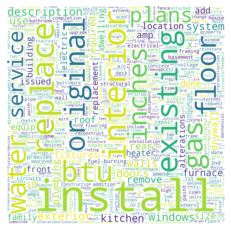

In [40]:
description_list_final = house_permit_from_file_filter['tokenized_final'].tolist()
word_list_final = []
for sublist in description_list_final:
    for word in sublist:
        word_list_final.append(word)
word_frequency_dict_final = FreqDist(word_list_final)
wordcloud_description_final = WordCloud(max_words = 1000,
                              width = 2000,
                              height = 2000,
                              background_color = 'white'
                             ).generate_from_frequencies(frequencies = word_frequency_dict_final)
plt.figure()
plt.imshow(wordcloud_description_final, interpolation='bilinear')
plt.axis('off')
wordcloud_description_final.to_file('house_permit_final.png')

In [41]:
df_word_frequency = pd.DataFrame(word_frequency_dict_final.items(),columns=['word','frequency'])
df_word_frequency = df_word_frequency.sort_values(by = 'frequency', ascending = False).reset_index()
# del df_word_frequency['index']
print(word_frequency_dict_final['demolish'])
print(word_frequency_dict_final['demolition'])

1139
18024


In [42]:
# Get demolition data
demolition_list = set(['demolish', 'demolition'])
mask = house_permit_value_filter['tokenized_final'].apply(lambda x: 'demolition' in x or 'demolish' in x) 
df_demolition = house_permit_value_filter[mask]
df_demolition = df_demolition[df_demolition['cost'].notnull()]
df_demolition['cost'] = df_demolition['cost'].astype(float)
df_demolition = df_demolition.sort_values(by = 'year', ascending = False)

In [43]:
df_demolition.head()

,address,lat,long,PIN,date,description,tokenized_final,cost,value,year
39504,1516 E CLEMENT ST,39.270090,-76.592180,2004002,03/10/2020,scope of work: interior alterations to include...,"[scope, interior, alterations, include, interi...",5000.0,252900.0,2020
39890,1005 MOUNT HOLLY ST,39.298904,-76.680030,2523A018,03/06/2020,scope of work: interior/exterior alterations t...,"[scope, interior/exterior, alterations, includ...",25000.0,103800.0,2020
40330,4300 PARKMONT AVE,39.347350,-76.535855,5722022,03/19/2020,scope of work: interior alterations to include...,"[scope, interior, alterations, include, interi...",30000.0,162800.0,2020
40322,7182 MCCLEAN BLVD,39.371546,-76.567028,5288F001,03/12/2020,scope of work: interior/exterior alterations t...,"[scope, interior/exterior, alterations, includ...",15000.0,9307533.0,2020
40286,5908 BRACKENRIDGE AVE,39.362442,-76.615844,4983F018,03/18/2020,scope of work: interior alterations to include...,"[scope, interior, alterations, include, interi...",100000.0,246000.0,2020


In [44]:
demolition_over_time = px.scatter_mapbox(df_demolition,
                           lat = 'lat',
                           lon = 'long',
                           hover_name = 'address',
                           size = 'cost',
                           animation_frame = 'year',
                           center = dict(lat=39.2904, lon= -76.6122),
                           title = "Demolition over the time in Baltimore",
                           color_continuous_scale=px.colors.cyclical.IceFire,
                           size_max = 100,
                           zoom = 10,
                           )

In [45]:
demolition_over_time.write_html('demolition_over_time.html')

In [52]:
df_word_frequency2 = pd.DataFrame(word_frequency_dict_final.items(),columns=['word','frequency'])
df_word_frequency2 = df_word_frequency2.sort_values(by = 'frequency', ascending = False).reset_index()
# del df_word_frequency['index']
print(word_frequency_dict_final['sewage'])

640


In [53]:
# Get sewage data
sewage_list = set(['sewage'])
mask = house_permit_value_filter['tokenized_final'].apply(lambda x: 'sewage' in x) 
df_sewage = house_permit_value_filter[mask]
df_sewage = df_sewage[df_sewage['cost'].notnull()]
df_sewage['cost'] = df_sewage['cost'].astype(float)
df_sewage = df_sewage.sort_values(by = 'year', ascending = False)

In [54]:
df_sewage.head()

,address,lat,long,PIN,date,description,tokenized_final,cost,value,year
386932,840 W 35TH ST,39.329896,-76.630610,3532007,01/22/2019,scope of work: install a new electric water he...,"[scope, install, electric, water, heater, reco...",10400.0,151667.0,2019
27461,5901 E LOMBARD ST,39.295492,-76.548445,6333013,12/20/2019,pre-engineered flex module temporary construct...,"[pre-engineered, flex, module, temporary, cons...",80000.0,34396133.0,2019
28598,6002 WALLIS AVE,39.357691,-76.689255,4360057,11/14/2019,plumbing work only and reconstruct 1 interior...,"[plumbing, reconstruct, interior, gas, line, f...",20000.0,229800.0,2019
416914,3349 KESWICK RD,39.328135,-76.627839,3670A022A,01/09/2019,reconstruct all waste and water as per code; 3...,"[reconstruct, waste, water, full, baths, basem...",3500.0,163233.0,2019
24981,4701 HAZELWOOD AVE,39.341510,-76.534671,6019D001,10/18/2019,install one (1) 30 amp 240 volt dedicated bran...,"[install, one, amp, volt, dedicated, branch, c...",500.0,329500.0,2019


In [55]:
sewage_over_time = px.scatter_mapbox(df_sewage,
                           lat = 'lat',
                           lon = 'long',
                           hover_name = 'address',
                           size = 'cost',
                           animation_frame = 'year',
                           center = dict(lat=39.2904, lon= -76.6122),
                           title = "Sewage over the time in Baltimore",
                           color_continuous_scale=px.colors.cyclical.IceFire,
                           size_max = 100,
                           zoom = 10,
                           )

In [56]:
sewage_over_time.write_html('Sewage_over_time.html')

In [57]:
df_sewage.to_csv('Sewage_Permits.csv')

In [ ]:
# This is for previous test

# description_list_updated = house_permit_from_file_filter['no_symbols'].tolist()
# word_list = []
# for sublist in description_list_updated:
#     for word in sublist:
#         word_list.append(word)
# word_frequency_dict = FreqDist(word_list)
# df_word_frequency = pd.DataFrame(word_frequency_dict.items(),columns=['word','frequency'])
# df_word_frequency = df_word_frequency.sort_values(by = 'frequency', ascending = False).reset_index()
# # del df_word_frequency['index']
# df_word_frequency.head(50)

In [ ]:
# wordcloud_description_updated = WordCloud(max_words = 1000,
#                               width = 2000,
#                               height = 2000,
#                               background_color = 'white'
#                              ).generate_from_frequencies(frequencies = word_frequency_dict)
# plt.figure()
# plt.imshow(wordcloud_description_updated, interpolation='bilinear')
# plt.axis('off')

In [ ]:
# wordcloud_description_updated.to_file('house_permit.png')